In [190]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [191]:
import pickle

In [192]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [193]:
assert torch.cuda.is_available()

In [194]:
assert torch.backends.cudnn.enabled

In [195]:
from IPython.core import page
temp = page.page
page.page = print

%pycat scripts/data_imports.py

page.page=temp

from functools import reduce
import pandas as pd

path = "../data/"
train_path = path + "train-jpg/"
train = pd.read_csv(path + "train_v2.csv")

tags = list(reduce(lambda x, y: x | set(y.split()), train['tags'], set()))

for tag in tags:
    train[tag] = train['tags'].apply(lambda x: tag in x.split())

train = train.drop(labels='tags', axis=1)



In [196]:
%run scripts/data_imports.py

In [197]:
train

,image_name,agriculture,cloudy,clear,cultivation,conventional_mine,road,primary,artisinal_mine,bare_ground,partly_cloudy,haze,slash_burn,habitation,selective_logging,blow_down,water,blooming
0,train_0,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
1,train_1,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,train_2,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,train_3,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,train_4,True,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False
5,train_5,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
6,train_6,True,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False
7,train_7,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
8,train_8,True,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False
9,train_9,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False


In [198]:
override_idxs = False

if override_idxs == True:
    val_count = int(0.2*len(train.index))
    val_idxs = np.random.choice(train.index, size=val_count)
    output = open('val_idxs.pkl', 'wb')
    pickle.dump(val_idxs, output)
    output.close()

pkl_file = open('val_idxs.pkl', 'rb')

val_idxs = pickle.load(pkl_file)

pkl_file.close()

In [199]:
len(val_idxs)/len(train.index)

0.19998023666592554

# Create Model

In [200]:
image_size = 200
architecture = resnext101 # = resnext101_32
batch_size = 13

tfms = tfms_from_model(architecture, image_size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', batch_size, tfms, val_idxs, suffix='.jpg', test_name='test-merged')

In [201]:
learn = ConvLearner.pretrained(architecture, data, precompute=True)

In [202]:
learn.lr_find()

 89%|████████▉ | 2282/2550 [00:13<00:01, 165.50it/s, loss=0.395]

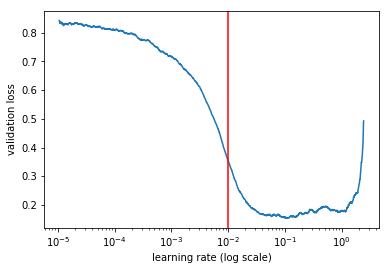

In [203]:
import matplotlib.pyplot as plt
learning_rate=1e-2
learn.sched.plot()
plt.axvline(x=learning_rate, color="red")

In [207]:
learn.fit(learning_rate, 1)

epoch      trn_loss   val_loss   <lambda>                       
    0      0.124892   0.111743   0.957596  


[array([0.11174]), 0.9575960708034937]

In [208]:
learn.precompute = False

In [17]:
learn.lr_find()

 90%|████████▉ | 2290/2550 [05:01<00:34,  7.60it/s, loss=0.481]

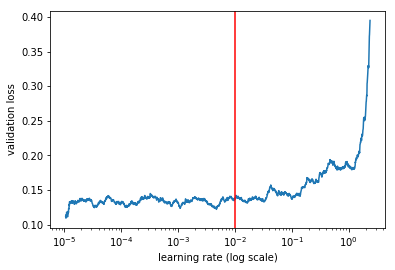

In [17]:
learning_rate=1e-2
learn.sched.plot()
plt.axvline(x=learning_rate, color="red")

In [18]:
learn.fit(learning_rate, 1, cycle_len=1)

epoch      trn_loss   val_loss   <lambda>                      
    0      0.136279   0.111745   0.956353  


[array([0.11174]), 0.9563533767166231]

In [19]:
learn.save('lastlayer')

In [20]:
learn.precompute = False

In [21]:
learn.unfreeze()

In [22]:
learn.load('lastlayer')

In [23]:
learn.unfreeze()

In [24]:
torch.cuda.empty_cache()

In [25]:
learn.lr_find()

 91%|█████████ | 2313/2550 [26:06<02:40,  1.48it/s, loss=0.545]

In [26]:
# 2359 mb bei batch_size=5

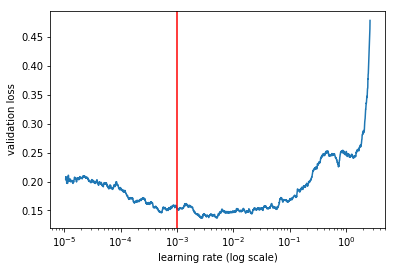

In [27]:
learning_rate=1e-3
learn.sched.plot()
plt.axvline(x=learning_rate, color="red")

In [28]:
lr=np.array([1e-5,1e-4,1e-3])

In [29]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                      
    0      0.147259   0.12235    0.952649  
    1      0.147706   0.114323   0.955247                      
    2      0.134546   0.113946   0.955953                      
    3      0.127321   0.111081   0.956786                      
    4      0.120946   0.10662    0.958486                      
    5      0.126457   0.104933   0.959288                      
    6      0.124246   0.107896   0.957524                      
    7      0.122554   0.104467   0.9596                        
    8      0.122183   0.101752   0.960595                      
    9      0.123967   0.102128   0.959929                      
    10     0.122466   0.101754   0.960226                      
    11     0.108289   0.099152   0.962062                      
    12     0.118545   0.101074   0.960795                      
    13     0.112183   0.101166   0.96049                       
    14     0.111199   0.102929   0.959745                   

[array([0.10293]), 0.9597447289665989]

In [30]:
# batch_size 5: 2404mb (2299mb anaconda)
# batch_size 10: 3324mb (3086mb anaconda)
# batch_size 13: 3899mb (3571mb anaconda)

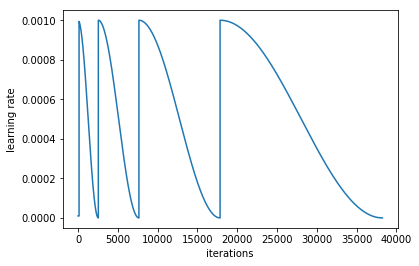

In [31]:
learn.sched.plot_lr()

In [32]:
#learn.save('layers_all')

In [ ]:
torch.cuda.empty_cache()

# Larger Images

In [36]:
learn.load('layers_all')

In [37]:
image_size2 = 220
batch_size2 = 210
tfms2 = tfms_from_model(architecture, image_size2, aug_tfms=transforms_top_down, max_zoom=1.1)
data2 = ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', batch_size2, tfms2, val_idxs, suffix='.jpg', test_name='test-jpg')

In [38]:
learn.set_data(data2)

In [39]:
learn.freeze()

In [40]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                    
    0      0.116555   0.177579   0.951254  


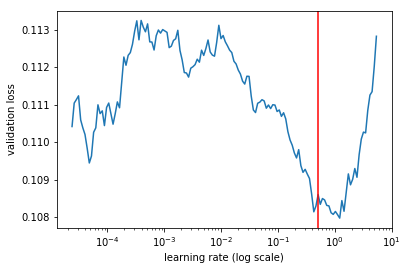

In [41]:
learning_rate2=5e-1
learn.sched.plot()
plt.axvline(x=learning_rate2, color="red")

In [ ]:
!nvidia-smi

In [43]:
learn.fit(learning_rate2, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.103128   0.094675   0.963521  
    1      0.102923   0.093585   0.96393                     
    2      0.099251   0.092733   0.963906                     
    3      0.098997   0.093392   0.964026                     
    4      0.097917   0.092122   0.964138                     
    5      0.096825   0.091405   0.964732                     
    6      0.095921   0.091162   0.964459                     
    7      0.097438   0.092373   0.964154                     
    8      0.096296   0.092751   0.964234                     
    9      0.095467   0.091406   0.964539                     
    10     0.09543    0.09052    0.964419                     
    11     0.093116   0.090466   0.964611                     
    12     0.092434   0.090061   0.964724                     
    13     0.091008   0.090009   0.964667                     
    14     0.092022   0.089904   0.964707                     


[array([0.0899]), 0.9647074678263613]

In [44]:
#learn.save('highres')

# Test Time Augmentation

In [70]:
torch.cuda.empty_cache()

In [209]:
learn.load('highres')

In [18]:
log_probs_TTA,targets = learn.TTA()

In [19]:
log_probs_TTA.shape

(5, 7337, 17)

In [20]:
log_probs_TTA = np.mean(log_probs_TTA, axis=0)

In [21]:
log_probs_TTA.shape

(7337, 17)

In [22]:
from sklearn.metrics import log_loss

In [23]:
log_probs, targets = learn.predict_with_targs()

In [24]:
log_loss(targets,log_probs)

4.160538755124467

In [25]:
from functools import reduce
def combined_loss(targets, probs):
    return reduce(lambda x,y: x + log_loss(y[0], y[1]), zip(targets.T, probs.T), 0)

In [30]:
def avg_loss(targests, probs):
    return combined_loss(targets, probs) / len(targets.T)

In [26]:
combined_loss(targets, log_probs)

1.5633127759890746

In [27]:
combined_loss(targets, log_probs_TTA)

1.478061481503625

In [31]:
avg_loss(targets, log_probs)

0.09195957505818086

In [32]:
avg_loss(targets, log_probs_TTA)

0.086944793029625

## Prediction

In [210]:
log_probs_test, y_test = learn.TTA(is_test=True)

In [211]:
log_probs_test.shape

(5, 61191, 17)

In [212]:
classes = np.array(data.classes, dtype=str)

In [213]:
classes

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy',
       'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype='<U17')

In [214]:
from pathlib import Path

In [215]:
filenames = [Path(f).stem for f in data.test_ds.fnames]

In [216]:
filenames

['file_7175',
 'test_38418',
 'test_4145',
 'test_38927',
 'test_16095',
 'file_8436',
 'test_34980',
 'test_28995',
 'test_33882',
 'test_39354',
 'test_27085',
 'file_18642',
 'test_8207',
 'test_4443',
 'file_7388',
 'test_5513',
 'test_16515',
 'test_20333',
 'test_36207',
 'file_7086',
 'file_2174',
 'file_725',
 'test_32755',
 'file_1644',
 'test_26436',
 'file_6414',
 'test_33590',
 'file_2098',
 'test_19050',
 'test_26045',
 'file_5632',
 'file_6427',
 'test_14980',
 'test_33977',
 'file_519',
 'test_22844',
 'test_3541',
 'file_12213',
 'test_13231',
 'test_25463',
 'test_29970',
 'file_17212',
 'file_3971',
 'file_19965',
 'test_36760',
 'test_14515',
 'test_8599',
 'file_18980',
 'test_35720',
 'file_17821',
 'file_19583',
 'file_4171',
 'file_1306',
 'file_19161',
 'file_408',
 'file_9021',
 'test_25900',
 'test_11355',
 'test_14922',
 'test_1284',
 'file_2813',
 'test_7814',
 'test_22437',
 'test_37443',
 'file_16565',
 'test_31232',
 'test_16523',
 'file_1736',
 'file_194

In [219]:
index = np.array([f.split(sep='_')[1] for f in filenames], dtype=int)

In [220]:
index

array([ 7175, 38418,  4145, ...,  3604,  5548, 24044])

In [221]:
preds_test = np.average(log_probs_test, axis=0)

In [222]:
preds_test.shape

(61191, 17)

In [223]:
preds_test[1]

array([0.22159, 0.00505, 0.01375, 0.02005, 0.00301, 0.99005, 0.00034, 0.00047, 0.38162, 0.00948, 0.00227,
       0.00614, 0.99933, 0.00969, 0.00745, 0.00361, 0.21127], dtype=float32)

In [224]:
preds_test_df = pd.DataFrame(preds_test, columns=data.classes, index=filenames, )

In [225]:
preds_test_df

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
file_7175,0.972523,2.377574e-04,0.005893,0.001593,0.001095,0.973457,0.000302,0.000340,0.464931,0.967517,0.013420,0.011091,0.994728,0.982506,0.007866,0.012863,0.024442
test_38418,0.221593,5.054711e-03,0.013750,0.020050,0.003008,0.990054,0.000343,0.000466,0.381615,0.009477,0.002274,0.006139,0.999330,0.009688,0.007446,0.003608,0.211273
test_4145,0.004947,2.403244e-05,0.000216,0.000121,0.000125,0.010496,0.946102,0.000021,0.000630,0.000175,0.030154,0.002703,0.038584,0.000866,0.000057,0.000054,0.017336
test_38927,0.362097,1.779128e-04,0.016272,0.015426,0.004075,0.970321,0.000229,0.000225,0.559825,0.003548,0.002397,0.032828,0.999755,0.002605,0.004312,0.015669,0.007871
test_16095,0.525362,1.225867e-04,0.003327,0.037619,0.009974,0.994329,0.000276,0.000330,0.133950,0.135232,0.000741,0.008615,0.998758,0.168460,0.054720,0.006875,0.015788
file_8436,0.007595,9.154534e-06,0.000050,0.000641,0.000165,0.001752,0.000041,0.000034,0.002938,0.001078,0.000141,0.995796,0.999964,0.004702,0.000518,0.000062,0.023602
test_34980,0.002142,8.061366e-06,0.000055,0.020840,0.000423,0.997348,0.000444,0.000018,0.000432,0.002069,0.000372,0.000727,0.999331,0.002939,0.003940,0.000015,0.001992
test_28995,0.760833,6.995512e-04,0.327217,0.001349,0.001659,0.916427,0.002928,0.003318,0.050434,0.029550,0.118366,0.009620,0.793914,0.148468,0.000956,0.003425,0.308948
test_33882,0.005990,3.693792e-05,0.000219,0.000098,0.000082,0.038260,0.925979,0.000028,0.000900,0.000315,0.025782,0.001475,0.043322,0.001577,0.000047,0.000062,0.037149
test_39354,0.754731,2.401863e-04,0.180836,0.000509,0.000603,0.947759,0.001628,0.001156,0.068348,0.011291,0.033151,0.004322,0.948506,0.102917,0.000473,0.004371,0.535971


In [226]:
labels = np.array([" ".join(classes[pred>0.5]) for pred in preds_test])

In [227]:
res = np.array(tuple(zip(filenames, labels)))

In [228]:
res.shape

(61191, 2)

In [229]:
res_df = pd.DataFrame(res, columns=['image_name', 'tags'], index=index)

In [230]:
res_df

,image_name,tags
7175,file_7175,agriculture clear habitation primary road
38418,test_38418,clear primary
4145,test_4145,cloudy
38927,test_38927,clear cultivation primary
16095,test_16095,agriculture clear primary
8436,file_8436,partly_cloudy primary
34980,test_34980,clear primary
28995,test_28995,agriculture clear primary
33882,test_33882,cloudy
39354,test_39354,agriculture clear primary water


In [231]:
res_df=res_df.sort_index()

In [232]:
res_df

,image_name,tags
0,test_0,clear primary
0,file_0,clear primary
1,file_1,agriculture partly_cloudy primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
2,file_2,clear cultivation primary
3,file_3,clear primary water
3,test_3,partly_cloudy primary
4,file_4,agriculture partly_cloudy primary road
4,test_4,partly_cloudy primary


In [233]:
res_df.to_csv('submission.csv', index=False)

In [234]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission.csv -m "Test Kaggle Submission Process form Jupyter"

Successfully submitted to Planet: Understanding the Amazon from Space

In [ ]:
learn.activations

In [ ]:
learn.get_activations()

In [ ]:
learn.get_layer_groups()

In [ ]:
learn.model

In [ ]:
learn.summary?

In [ ]:
#learn.predict